https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html

In [8]:
!pip install stellargraph

     |████████████████████████████████| 440kB 4.6MB/s 


Data preparation using Pandas and scikit-learn: loading the graph from CSV files, doing some basic introspection, and splitting it into train, test and validation splits for ML

Creating the GCN layers and data input using StellarGraph

Training and evaluating the model using TensorFlow Keras, Pandas and scikit-learn

In [9]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [10]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [11]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [12]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


In [14]:
G.nodes()

Int64Index([  31336, 1061127, 1106406,   13195,   37879, 1126012, 1107140,
            1102850,   31349, 1106418,
            ...
             626531, 1131180, 1130454, 1131184, 1128974, 1128975, 1128977,
            1128978,  117328,   24043],
           dtype='int64', length=2708)

In [15]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [16]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Probabilistic_Methods,22
Genetic_Algorithms,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


In [17]:
train_subjects.head()

755217     Reinforcement_Learning
116545         Genetic_Algorithms
100935         Genetic_Algorithms
1132073           Neural_Networks
188471     Reinforcement_Learning
Name: subject, dtype: object

In [18]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [34]:
import networkx as nx
A = G.to_networkx()
A.get_edge_data(854434, 3243)

{0: {'label': 'cites', 'weight': 1.0}}

In [39]:
list(A.nodes(data=True))[0:5]

[(31336,
  {'feature': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
   'label': 'paper'}),
 (1061127,
  {'feature': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
   'label': 'paper'}),
 (1106406,
  {'feature': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
   'label': 'paper'}),
 (13195,
  {'feature': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
   'label': 'paper'}),
 (37879,
  {'feature': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
   'label': 'paper'})]

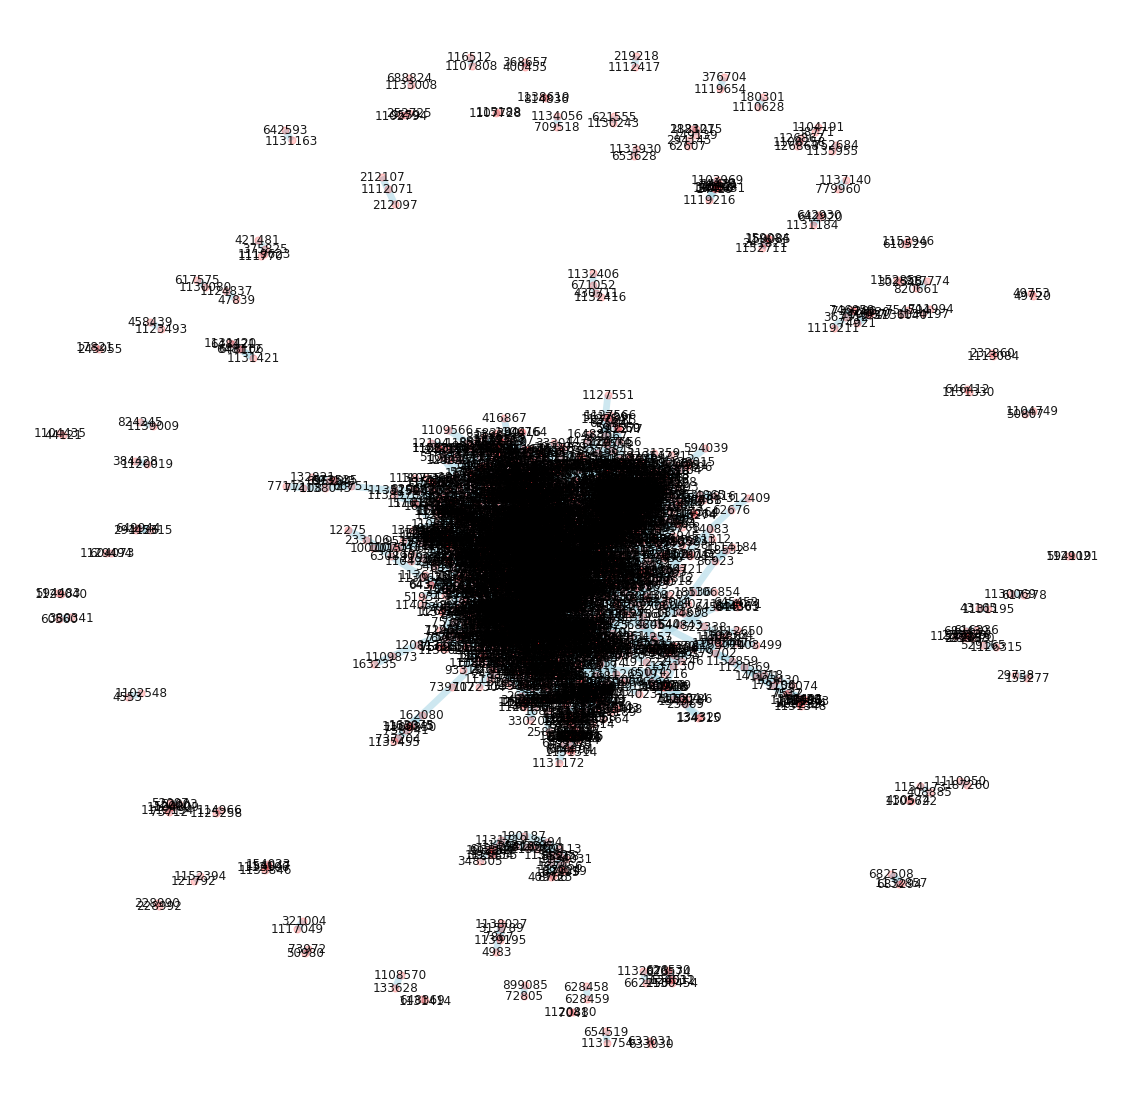

In [37]:
import networkx as nx
from matplotlib import pyplot as plt

edge_labels = nx.get_edge_attributes(A, 'weight') # weight
nodelist = A.nodes()

import numpy as np
from sklearn.preprocessing import normalize
z = np.array(list(edge_labels.items()), dtype=object)
z[:, 1] = normalize(z[:, 1].reshape(1, z.shape[0]))

edge_labels_normalised = dict(z)
edge_labels_normalised.update((x, y*500) for x, y in edge_labels_normalised.items())

plt.figure(figsize=(20,20))

#pos = nx.shell_layout(G)
pos = nx.spring_layout(A)
nx.draw_networkx_nodes(A,pos, 
                       nodelist=nodelist,
                       node_size=50,
                       node_color='red',
                       alpha=0.2)
nx.draw_networkx_edges(A,pos,
                       edgelist = edge_labels_normalised.keys(),
                       width=list(edge_labels_normalised.values()),
                       edge_color='lightblue',
                       alpha=0.6)
nx.draw_networkx_labels(A, pos=pos,
                        labels=dict(zip(nodelist,nodelist)),
                        font_color='black',
                        alpha=0.9)
plt.box(False)
plt.show()

In [40]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [41]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [42]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [43]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [44]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [45]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [46]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [47]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [48]:
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/20
1/1 - 1s - loss: 1.9568 - acc: 0.1357 - val_loss: 1.9167 - val_acc: 0.2900
Epoch 2/20
1/1 - 0s - loss: 1.8932 - acc: 0.3429 - val_loss: 1.8727 - val_acc: 0.3560
Epoch 3/20
1/1 - 0s - loss: 1.8469 - acc: 0.4571 - val_loss: 1.8162 - val_acc: 0.3520
Epoch 4/20
1/1 - 0s - loss: 1.7689 - acc: 0.4500 - val_loss: 1.7518 - val_acc: 0.3660
Epoch 5/20
1/1 - 0s - loss: 1.6670 - acc: 0.4714 - val_loss: 1.6821 - val_acc: 0.3960
Epoch 6/20
1/1 - 0s - loss: 1.6143 - acc: 0.4643 - val_loss: 1.6102 - val_acc: 0.4260
Epoch 7/20
1/1 - 0s - loss: 1.5104 - acc: 0.5000 - val_loss: 1.5374 - val_acc: 0.4540
Epoch 8/20
1/1 - 0s - loss: 1.3840 - acc: 0.5071 - val_loss: 1.4587 - val_acc: 0.4840
Epoch 9/20
1/1 - 0s - loss: 1.3063 - acc: 0.5214 - val_loss: 1.3731 - val_acc: 0.4940
Epoch 10/20
1/1 - 0s - loss: 1.2051 - acc: 0.5429 - val_loss: 1.2911 - val_acc: 0.5180
Epoch 11/20
1/1 - 0s - loss: 1.1408 - acc: 0.5643 - val_loss: 1.2139 - val_acc: 0.5840
Epoch 12/20
1/1 - 0s - loss: 1.0069 - acc: 0.6357 - 

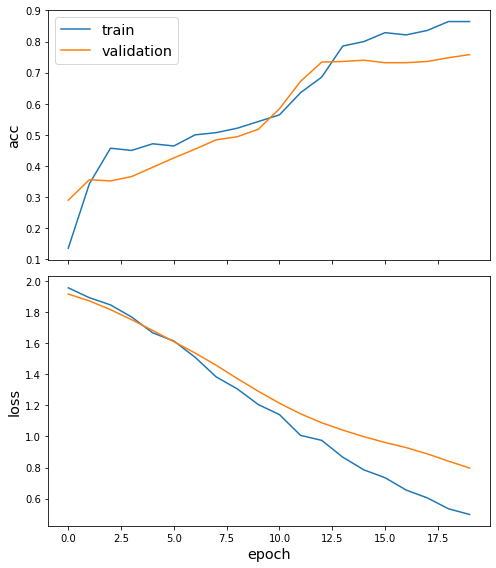

In [49]:
sg.utils.plot_history(history)

In [50]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [51]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 61ms/step - loss: 0.8392 - acc: 0.7321

Test Set Metrics:
	loss: 0.8392
	acc: 0.7321


In [52]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [53]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [54]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Probabilistic_Methods,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Genetic_Algorithms,Reinforcement_Learning
13195,Genetic_Algorithms,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Case_Based,Theory
1102850,Probabilistic_Methods,Neural_Networks
31349,Probabilistic_Methods,Neural_Networks
1106418,Theory,Theory


In [55]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [56]:
emb = embedding_model.predict(all_gen)
emb.shape

(1, 2708, 16)

In [57]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE  # or PCA

In [58]:
X = emb.squeeze(0)
X.shape

(2708, 16)

In [59]:
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

(2708, 2)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset'),
 None]

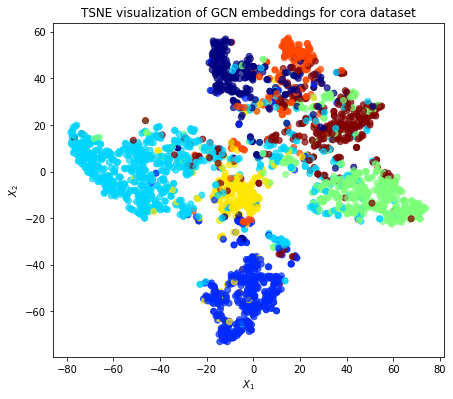

In [60]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)